In [1]:
%matplotlib widget
import numpy as np
import scipy
import xarray as xr
import matplotlib.pyplot as plt
import pywt

In [2]:
ds_fn = "E:/research_data/2022_harmonic_gravity_waves/preprocessed_images/bore_ex.nc"
ds = xr.open_dataset(ds_fn)

In [3]:
ds.sel(time="2018-02-11T08")

<xarray.Dataset>
Dimensions:   (x: 2304, y: 4064, time: 1)
Coordinates:
    lon       (x, y, time) float32 ...
    lat       (x, y, time) float32 ...
  * time      (time) datetime64[ns] 2018-02-11T08:37:31
Dimensions without coordinates: x, y
Data variables:
    rad255    (x, y, time) float64 ...
    senzen    (x, y, time) float32 ...
    senazi    (x, y, time) float32 ...
    senrange  (x, y, time) float32 ...
    solzen    (x, y, time) float32 ...
    solazi    (x, y, time) float32 ...
    lunzen    (x, y, time) float32 ...
    lunazi    (x, y, time) float32 ...

In [4]:
img_array = ds.sel(time="2018-02-11T08").isel(time=0).rad255.values

In [5]:
img_array.shape

(2304, 4064)

In [6]:
img_array_norm = (img_array - img_array.mean()) / img_array.std()

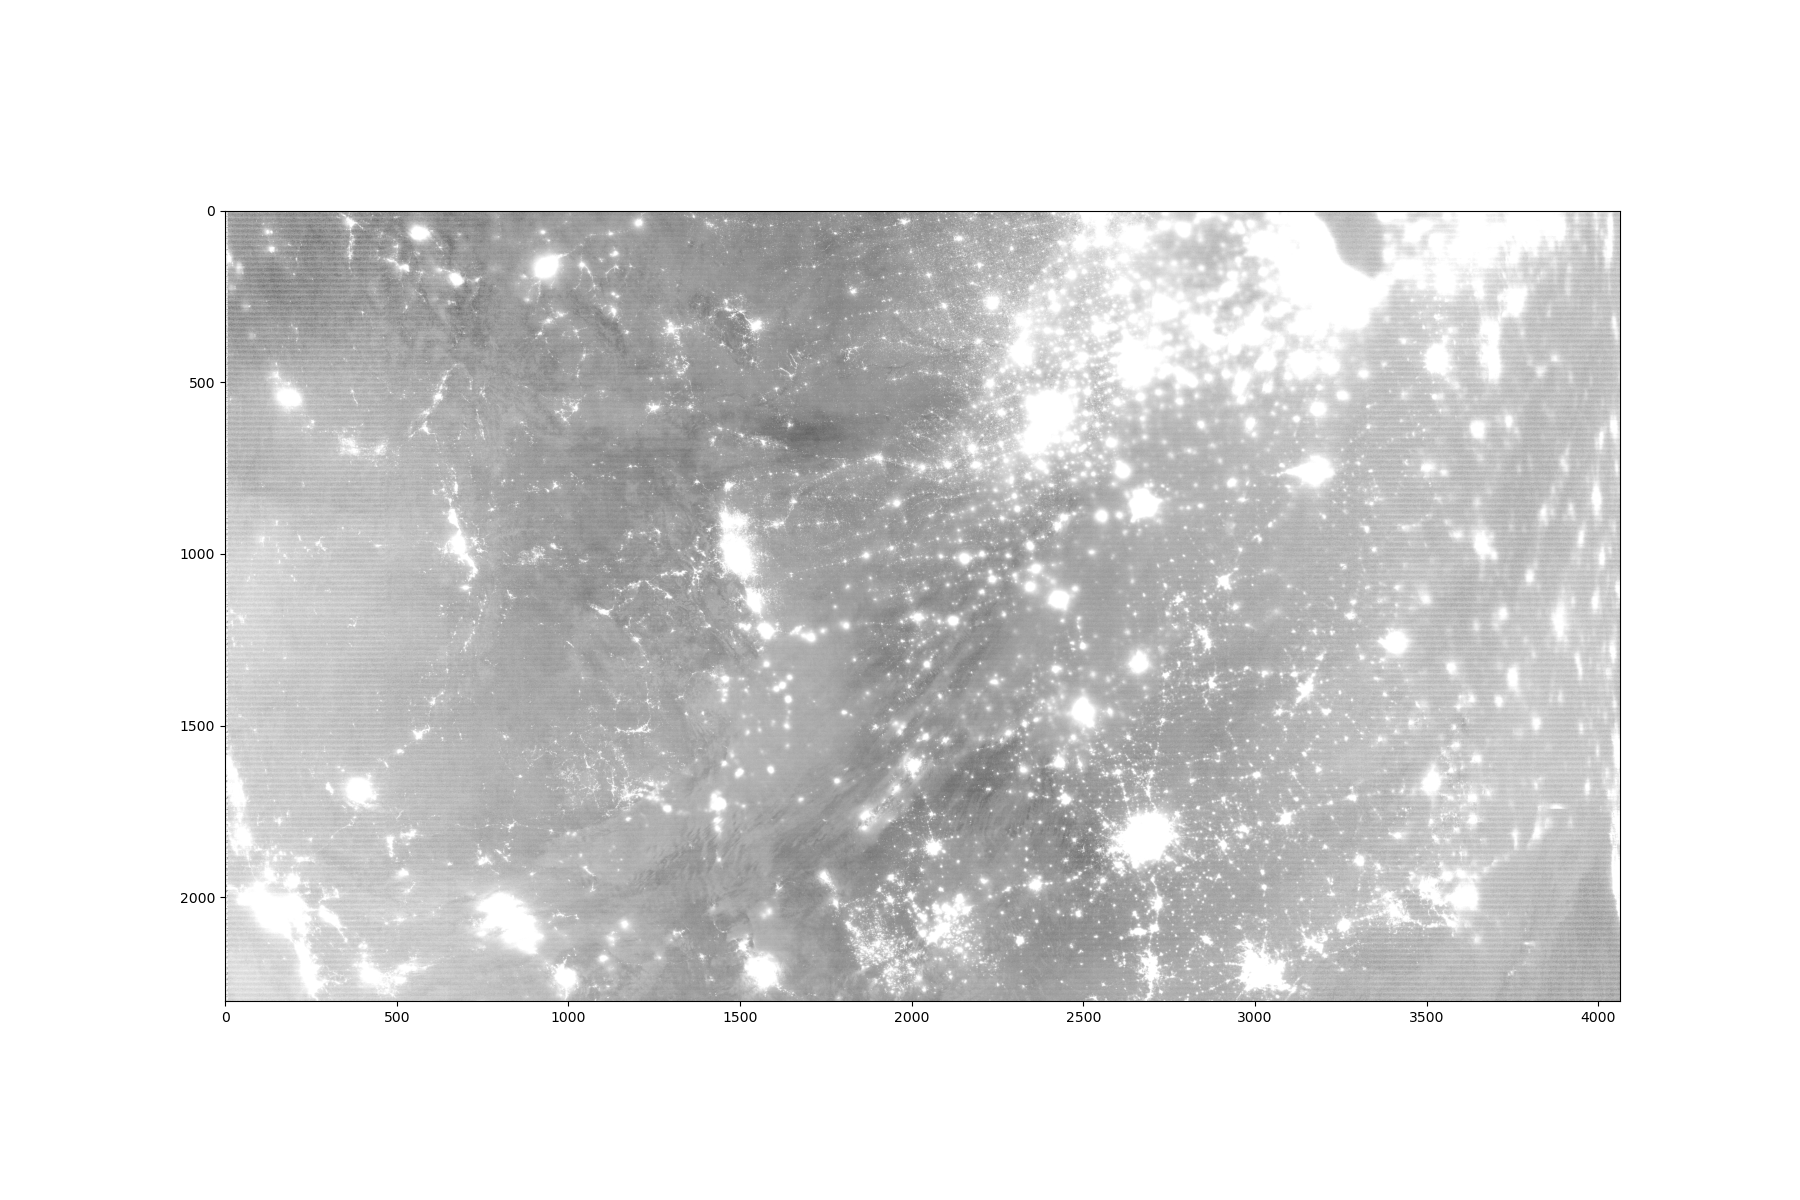

In [7]:
F, ax = plt.subplots(figsize=(18, 12))
ax.imshow(img_array, cmap='gray')

In [130]:
col = img_array_norm[:, 20]

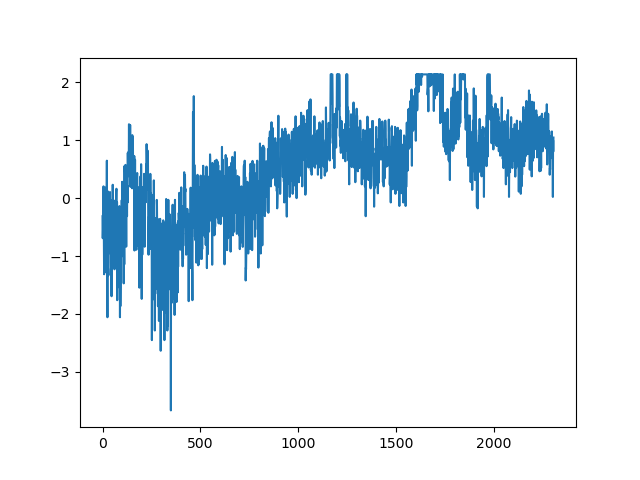

In [131]:
F, ax = plt.subplots()
ax.plot(col)

In [198]:
filt_col = wt_denoise_col(col, 'haar')

In [132]:
col.shape

(2304,)

In [231]:
wv = pywt.Wavelet('coif1')
coeffs = pywt.wavedec(col, wv)

In [232]:
d_coeffs = coeffs[1:]
a_coeffs = [coeffs[0]]
for d_coeff in d_coeffs[:-1]:
    a_coeffs.append(pywt.idwt(a_coeffs[-1][:len(d_coeff)], d_coeff, haar_wv))

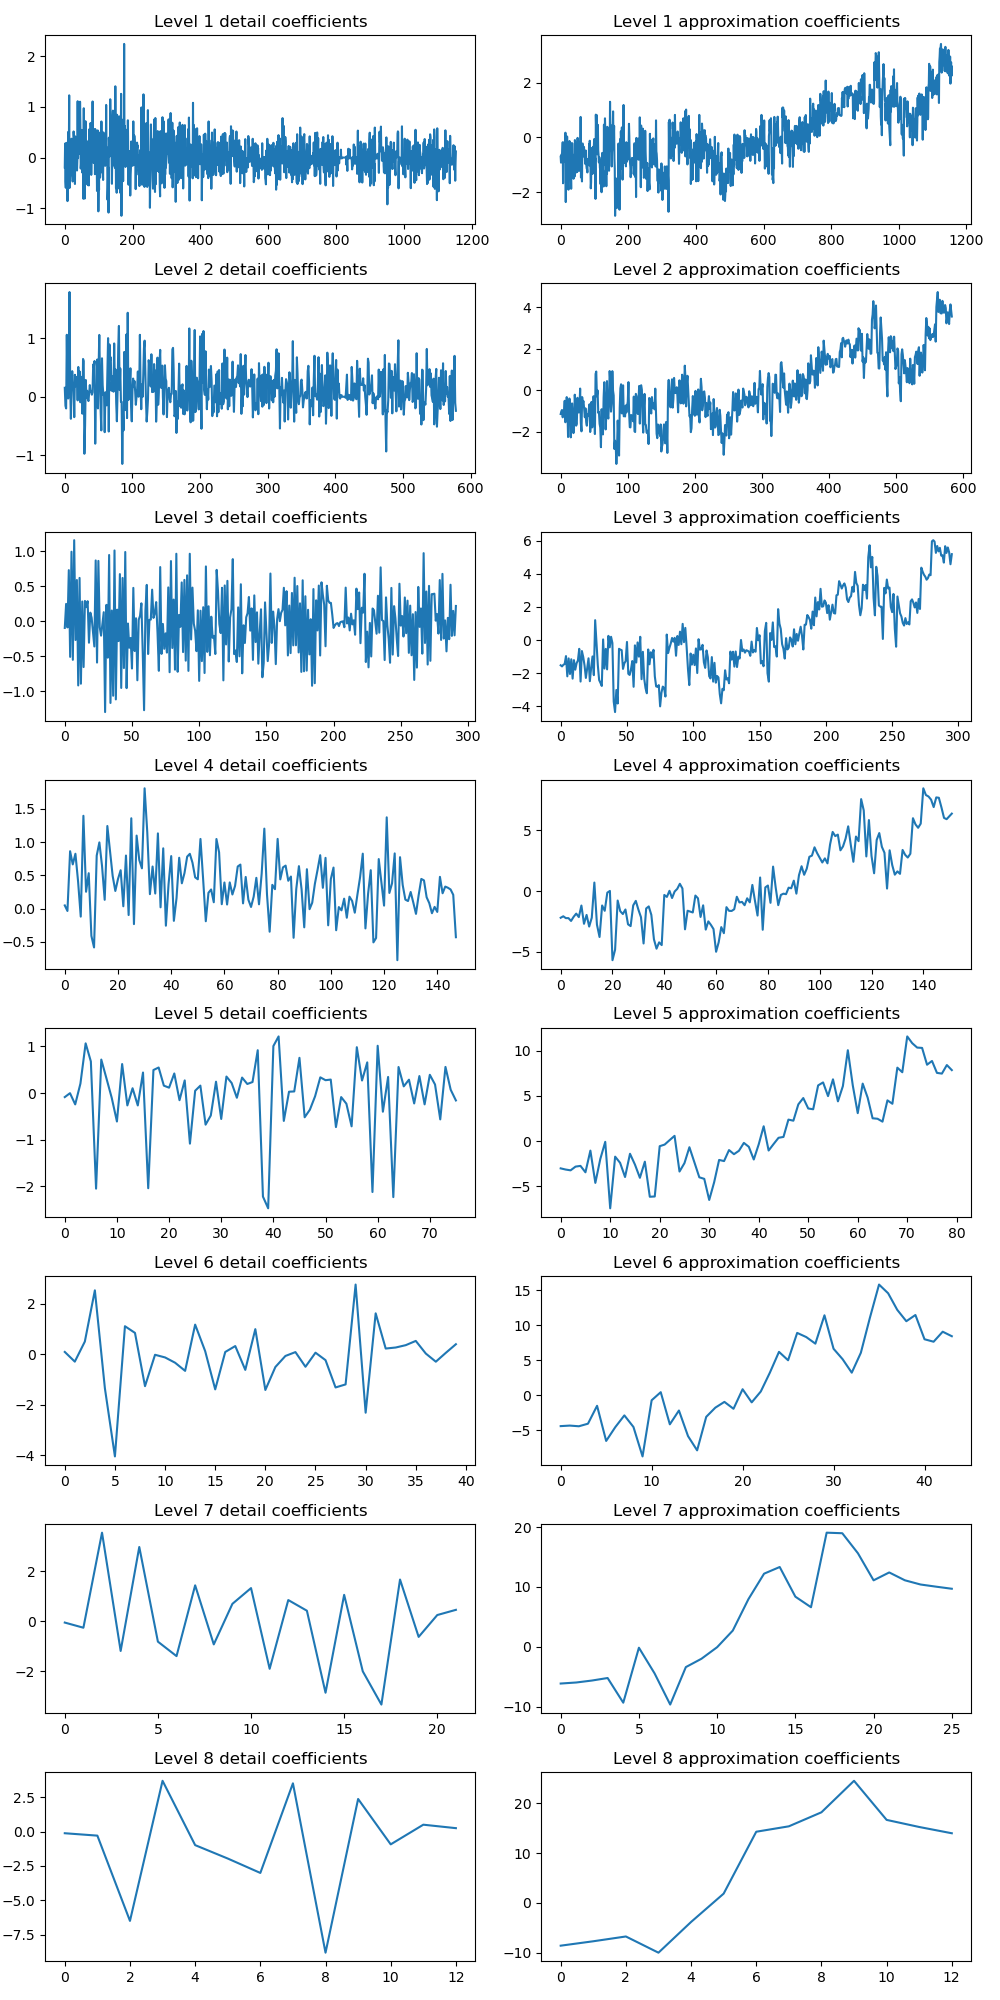

In [233]:
F, axes = plt.subplots(len(d_coeffs), 2, figsize=(10, 20))
for i in range(len(d_coeffs)):
    axes[i, 0].plot(d_coeffs[len(d_coeffs) - 1 - i])
    axes[i, 0].set_title(f'Level {i + 1} detail coefficients')
    axes[i, 1].plot(a_coeffs[len(d_coeffs) - 1 - i])
    axes[i, 1].set_title(f'Level {i + 1} approximation coefficients')
F.tight_layout()

In [136]:
Sj = [np.abs(d_coeff).max() / np.sum(np.abs(d_coeff)) for d_coeff in d_coeffs]

In [137]:
Sj

[1.0,
 0.5945034310695446,
 0.3312532599828688,
 0.2626749943481834,
 0.17876212873271335,
 0.14094571455149849,
 0.060169787860458845,
 0.02422553537970022,
 0.020643802667877506,
 0.011758258483370199,
 0.005789868564096366]

In [138]:
level = 1
while Sj[-level] < 0.2:
    level += 1
level -= 1

In [177]:
level_Sj = Sj[-level:]

In [139]:
Aj = a_coeffs[-level]
level_coeffs = d_coeffs[-level:]
level_coeffs.insert(0, Aj)

In [142]:
# Compute threshold levels
def peak_to_sum(coeffs):
    pos_coeffs = coeffs[coeffs >= 0]
    neg_coeffs = coeffs[coeffs < 0]
    
    S_high = np.max(pos_coeffs) / np.sum(pos_coeffs) 
    S_low = np.max(-neg_coeffs) / np.sum(-neg_coeffs)
    
    return (S_low, S_high)

In [161]:
(S_ref_low, S_ref_high) = np.mean([peak_to_sum(coeffs[-level]), peak_to_sum(coeffs[-(level + 1)])], axis=1)

In [169]:
level_means = [level.mean() for level in level_coeffs]
level_std = [level.std() for level in level_coeffs]

In [175]:
kappa_mins = []
for i in range(len(level_coeffs)):
    kappa_L_min = (level_means[i] + np.max(-level_coeffs[i][level_coeffs[i] < 0])) / level_std[i]
    kappa_H_min = (np.max(level_coeffs[i][level_coeffs[i] >= 0]) - level_means[i]) / level_std[i]
    
    kappa_mins.append((kappa_L_min, kappa_H_min))

In [180]:
S_j_low, S_j_high = peak_to_sum(level_coeffs[0])
kappa_L = ((S_ref_low - S_j_low) / S_ref_low) * kappa_mins[0][0]
kappa_H = ((S_ref_high - S_j_high) / S_ref_high) * kappa_mins[0][1]

theta_L = level_means[0] - kappa_L * level_std[0]
theta_H = level_means[0] + kappa_H * level_std[0]

level_thresh = [(theta_L, theta_H)]

for i in range(1, len(level_coeffs)):
    if level_Sj[i - 1] < 0.01:
        level_thresh.append(kappa_mins[i])
    else:
        S_j_low, S_j_high = peak_to_sum(level_coeffs[i])
        kappa_L = ((S_ref_low - S_j_low) / S_ref_low) * kappa_mins[i][0]
        kappa_H = ((S_ref_high - S_j_high) / S_ref_high) * kappa_mins[i][1]
    
    theta_L = level_means[i] - kappa_L * level_std[i]
    theta_H = level_means[i] + kappa_H * level_std[i]
    
    level_thresh.append((theta_L, theta_H))

In [181]:
level_thresh

[(14.057820564955847, 14.405407285262974),
 (1.6734083314593293, 1.6384382222868246),
 (-1.3114008144576115, 0.6799704428840053),
 (-1.388645342106999, 1.3290140614766013),
 (-0.3070940288895938, 2.0401373789332),
 (-1.8876144059956939, 1.2607300204897411),
 (-1.6789387414200994, 1.0791492401863843),
 (3.584458460783664, 4.967628145947059),
 (-1.6267633316013215, 1.1439813679280049)]

In [190]:
filt_level_coeffs = []
for i in range(len(level_coeffs)):
    filt_level_coeffs.append(np.where(np.logical_and(level_thresh[i][0] <= level_coeffs[i], level_coeffs[i] <= level_thresh[i][1]), 0, level_coeffs[i]))

In [192]:
filt_col = pywt.waverec(filt_level_coeffs, haar_wv)

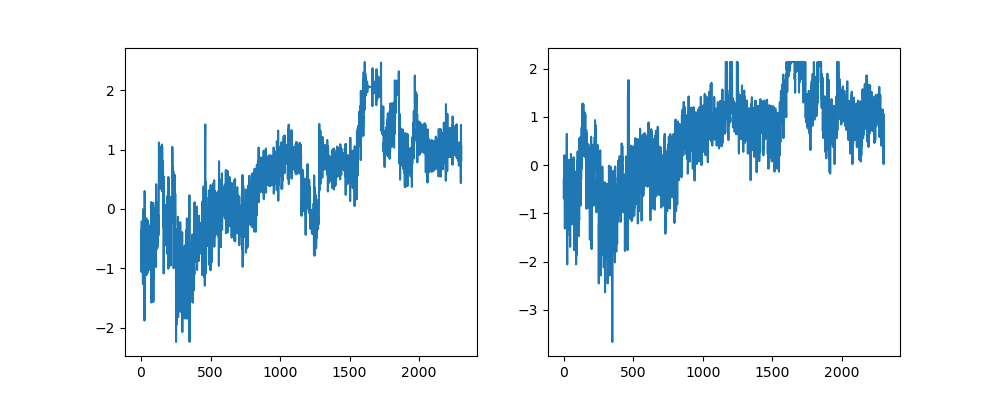

In [195]:
F, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(filt_col)
ax[1].plot(col)

In [202]:
# Compute threshold levels
def peak_to_sum(coeffs):
    pos_coeffs = coeffs[coeffs >= 0]
    neg_coeffs = coeffs[coeffs < 0]
    
    if pos_coeffs.size > 0:
        S_high = np.max(pos_coeffs) / np.sum(pos_coeffs) 
    else:
        S_high = 1.0
    if neg_coeffs.size > 0:
        S_low = np.max(-neg_coeffs) / np.sum(-neg_coeffs)
    else:
        S_low = 1.0
    
    return (S_low, S_high)

In [234]:
def wt_denoise_col(col, wavelet, level=None):
    wv = pywt.Wavelet(wavelet)
    coeffs = pywt.wavedec(col, wv)
    
    d_coeffs = coeffs[1:]
    a_coeffs = [coeffs[0]]
    for d_coeff in d_coeffs[:-1]:
        a_coeffs.append(pywt.idwt(a_coeffs[-1][:len(d_coeff)], d_coeff, wv))
        
    Sj = [np.abs(d_coeff).max() / np.sum(np.abs(d_coeff)) for d_coeff in d_coeffs]
    
    if level is None:
        level = 1
        while Sj[-level] < 0.2:
            level += 1
        level -= 1
    
    level_Sj = Sj[-level:]
    
    Aj = a_coeffs[-level]
    level_coeffs = d_coeffs[-level:]
    level_coeffs.insert(0, Aj)
    
    (S_ref_low, S_ref_high) = np.mean([peak_to_sum(coeffs[-level]), peak_to_sum(coeffs[-(level + 1)])], axis=1)
    
    level_means = [level.mean() for level in level_coeffs]
    level_std = [level.std() for level in level_coeffs]
    
    kappa_mins = []
    for i in range(len(level_coeffs)):
        kappa_L_min = (level_means[i] - np.min(level_coeffs[i])) / level_std[i]
        kappa_H_min = (np.max(level_coeffs[i]) - level_means[i]) / level_std[i]

        kappa_mins.append((kappa_L_min, kappa_H_min))
    
    S_j_low, S_j_high = peak_to_sum(level_coeffs[0])
    kappa_L = ((S_ref_low - S_j_low) / S_ref_low) * kappa_mins[0][0]
    kappa_H = ((S_ref_high - S_j_high) / S_ref_high) * kappa_mins[0][1]

    theta_L = level_means[0] - kappa_L * level_std[0]
    theta_H = level_means[0] + kappa_H * level_std[0]

    level_thresh = [(theta_L, theta_H)]

    for i in range(1, len(level_coeffs)):
        if level_Sj[i - 1] < 0.01:
            level_thresh.append(kappa_mins[i])
        else:
            S_j_low, S_j_high = peak_to_sum(level_coeffs[i])
            kappa_L = ((S_ref_low - S_j_low) / S_ref_low) * kappa_mins[i][0]
            kappa_H = ((S_ref_high - S_j_high) / S_ref_high) * kappa_mins[i][1]

        theta_L = level_means[i] - kappa_L * level_std[i]
        theta_H = level_means[i] + kappa_H * level_std[i]

        level_thresh.append((theta_L, theta_H))
        
    filt_level_coeffs = [level_coeffs[0]]
        
    for i in range(1, len(level_coeffs)):
        filt_level_coeffs.append(np.where(np.logical_and(level_thresh[i][0] <= level_coeffs[i], level_coeffs[i] <= level_thresh[i][1]), 0, level_coeffs[i]))
        
    filt_col = pywt.waverec(filt_level_coeffs, wv)
    
    return filt_col

In [237]:
filt_img_array = np.zeros_like(img_array_norm)
for i in range(filt_img_array.shape[1]):
    filt_img_array[:, i] = wt_denoise_col(img_array_norm[:, i], 'coif1', level=7)

C:\Users\lande\AppData\Local\Temp\ipykernel_23444\883311444.py:31: RuntimeWarning: invalid value encountered in double_scalars
  kappa_L_min = (level_means[i] - np.min(level_coeffs[i])) / level_std[i]
C:\Users\lande\AppData\Local\Temp\ipykernel_23444\883311444.py:32: RuntimeWarning: invalid value encountered in double_scalars
  kappa_H_min = (np.max(level_coeffs[i]) - level_means[i]) / level_std[i]


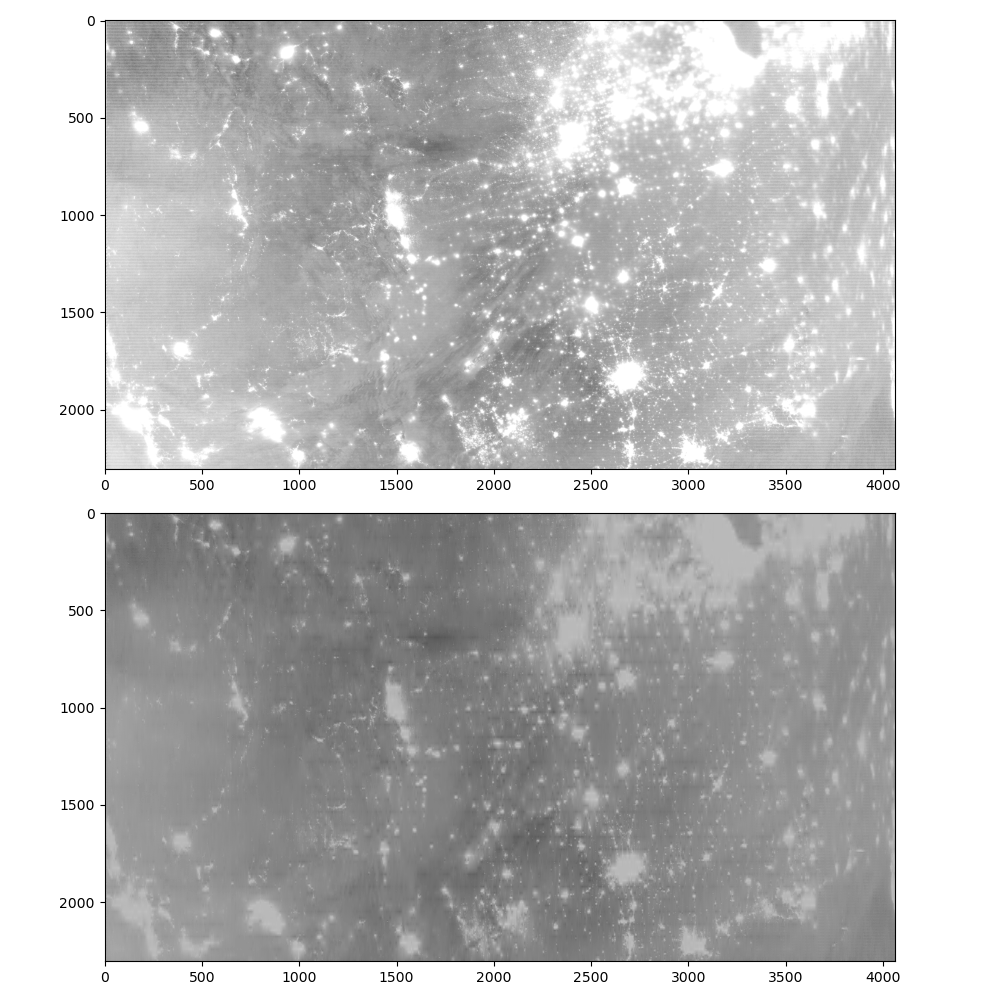

In [238]:
F, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].imshow(img_array_norm, cmap='gray')
ax[1].imshow(filt_img_array, cmap='gray')
F.tight_layout()